# LSTM on distance functions

In [1]:
from glob import glob
import json
from collections import defaultdict
import h5py
import pickle
from copy import deepcopy
import os

from keras.preprocessing.sequence import TimeseriesGenerator
import numpy as np
import pandas as pd
from keras.layers import LSTM, Dense, Activation, GaussianNoise
from keras.models import Input, Model
from keras.optimizers import Adam
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import energy_distance, wasserstein_distance
from sklearn.metrics import precision_score, recall_score, roc_auc_score

from canary.generator.utils import (
    buckets_to_points, X_metric_to_df, y_metric_to_df, buckets_to_points
)
from canary.models.metrics import (
    mse_times_100_tf, mse_times_100_np, log_bhattacharyya_dist, log_max_diff_dist, log_sum_of_diff_dist,
    log_wasserstein_dist, log_energy_dist
)
from canary.models.utils import percentile, plot_dists, plot_preds, calculate_dists

Using TensorFlow backend.


## Load the data

Loading the data previously generated with `generator` module

In [ ]:
DATA_DIR = '/home/aga/canary/data/'

In [2]:
X_train = dict()
for file in sorted(glob(os.path.join(DATA_DIR, '*_X_train.json'))):
    m = file.split('/')[-1].split('_X')[0]
    X_train[m] = json.load(open(file))
    
X_test = dict()
for file in sorted(glob(os.path.join(DATA_DIR, '*_X_test.json'))):
    m = file.split('/')[-1].split('_X')[0]
    X_test[m] = json.load(open(file))

y_anomalies = dict()
for file in sorted(glob(os.path.join(DATA_DIR, '*_y_test.json'))):
    m = file.split('/')[-1].split('_y')[0]
    y_anomalies[m] = json.load(open(file))
    
y_pred = dict()
for m, hist in X_test.items():
    y_pred[m] = dict.fromkeys(hist['data'], 0)

y_pred_proba = dict()
for m, hist in X_test.items():
    y_pred_proba[m] = dict.fromkeys(hist['data'], 0)

## Calculate the distances on train and test

First, we convert the data from histograms to distanced between next days as the LSTM works on the distances.

Calculated distances:
 - logarithm of Bhattacharyya distance
 - logarithm of Wasserstein distance
 - logarithm of energy distance
 - logarithm of maximum difference between corresponding buckets
 - logarithm of sum of difference between corresponding buckets
 
Logarithm is a form of normalization of the distances.
The distances were chosen arbitrary, the more diversed distances, the better.

In [ ]:
bucket_dists = [log_bhattacharyya_dist, log_max_diff_dist, log_sum_of_diff_dist]
points_dists = [log_wasserstein_dist, log_energy_dist]

In [3]:
X_train_dists = {}
y_train_dists = {}
dists_train = calculate_dists(X_train, bucket_dists, points_dists)
for metric in X_train.keys():
    X_train_dists[metric] = np.transpose(
        np.array([dists_train[metric][func.__name__][:-1] for func in bucket_dists + points_dists])
    )
    y_train_dists[metric] = np.transpose(
        np.array([dists_train[metric][func.__name__][1:] for func in bucket_dists + points_dists])
    )

In [4]:
X_test_dists = {}
y_test_dists = {}
dists_test = calculate_dists(X_test, bucket_dists, points_dists)
for metric in X_test.keys():
    X_test_dists[metric] = np.transpose(
        np.array([dists_test[metric][func.__name__][:-1] for func in bucket_dists + points_dists])
    )
    y_test_dists[metric] = np.transpose(
        np.array([dists_test[metric][func.__name__][1:] for func in bucket_dists + points_dists])
    )

Let's see one example of conversion between histogram (bottom) and distances (top) on the train set. We can clearly see the potential anomaly on the distance plot.

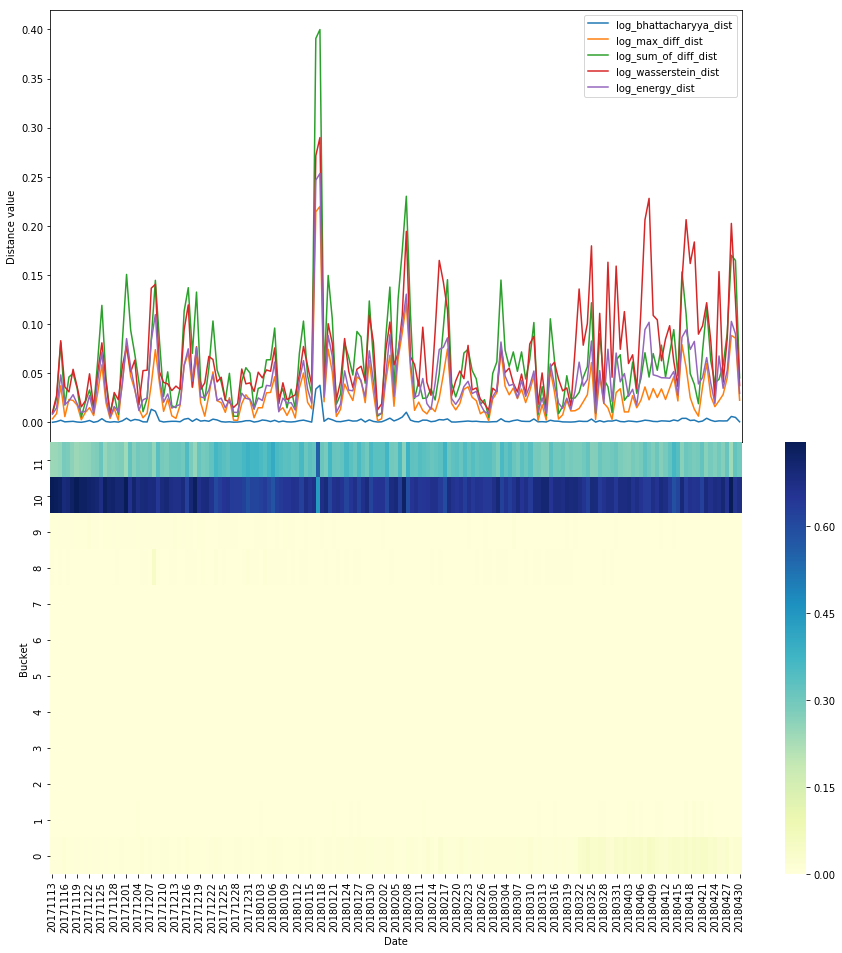

In [13]:
metric = 'A11Y_CONSUMERS'
dists_df = pd.DataFrame(dists_train[metric])
plot_dists(dists_df, X_train[metric])

## Parameters for the model

- `N_UNIT` is the size of the hidden state in LSTM
- `LENGTH` is the length of one sequence fed to the model
- `BATCH_SIZE` is number of sequences fed to the model at the same time
- `STRIDE` is the offset between the subsequent sequences
- `NOISE` is standard deviation of the gaussian noise applied during training

In [5]:
N_UNIT = 50
LENGTH = 14
BATCH_SIZE = 16
STRIDE = 7
NOISE = 5

## Delete too short merics

The train time series should be at least of length of `LENGTH + 2`, because we need some history to learn from.

In [6]:
metrics = list(X_train_dists.keys())
for m in metrics:
    if X_train_dists[m].shape[0] < LENGTH + 2:
        del X_train_dists[m]
        del X_train[m]
        del X_test[m]
        del X_test_dists[m]

## Model declaration

The model declaration is a bit unusual. There are two models: `model_train` and `model_test`. The models share all of the layers, the only difference is the test model returns also the state of the LSTM. We need this for proper behaviour after detecting the anomaly.

In [7]:
# Layers
lstm = LSTM(
    units=N_UNIT,
    return_sequences=True,
    return_state=True
)
dense = Dense(5)
noise = GaussianNoise(NOISE)

# model_train
input_train = Input(shape=(None, 5))
output_train = noise(input_train)
output_train, _, _ = lstm(output_train)
output_train = dense(output_train)
model_train = Model(inputs=[input_train], outputs=output_train)
model_train.compile(optimizer=Adam(lr=0.001), loss=mse_times_100_tf)

# model_test
input_test = Input(shape=(None, 5))
input_test_h = Input(shape=(N_UNIT,))
input_test_c = Input(shape=(N_UNIT,))
input_states = [input_test_h, input_test_c]
output_test, state_h, state_c = lstm(
    input_test, initial_state=input_states
)
output_states = [state_h, state_c]
output_test = dense(output_test)
model_test = Model(
    [input_test] + input_states,
    [output_test] + output_states,
)
model_test.compile(optimizer=Adam(lr=0.001), loss=mse_times_100_tf)

# batch generator
batch_gen_dict = {metric: iter(TimeseriesGenerator(
    X_train_dists[metric], y_train_dists[metric], 
    length=LENGTH + 1, stride=STRIDE, batch_size=BATCH_SIZE, shuffle=True,
    )) for metric in X_train.keys()}

## Training model

The model is trained on batches of size `BATCH_SIZE`, each observation is of length `LENGTH`. The model should predict the next day of data, so the ground truth is the same as train data, but moved one day forward.

In [8]:
def train_model(model, batch_gen_dict, n_iter=1000):
    train_loss = []
    for i in range(n_iter):
        metric = np.random.choice(list(batch_gen_dict.keys()))
        X, _ = next(batch_gen_dict[metric])
        y = X[:, 1:, :]
        X = X[:, :-1, :]
        train_loss.append(model.train_on_batch(X, y))
        if i % 100 == 0:
            print('BATCH: ', i, 'MEAN LOSS: ', np.mean(train_loss[-100:]))

In [9]:
train_model(model_train, batch_gen_dict, n_iter=10000)

BATCH:  0 MEAN LOSS:  288.27438
BATCH:  100 MEAN LOSS:  86.741905
BATCH:  200 MEAN LOSS:  59.50758
BATCH:  300 MEAN LOSS:  83.64087
BATCH:  400 MEAN LOSS:  67.21536
BATCH:  500 MEAN LOSS:  61.12997
BATCH:  600 MEAN LOSS:  64.779274
BATCH:  700 MEAN LOSS:  64.064606
BATCH:  800 MEAN LOSS:  55.79419
BATCH:  900 MEAN LOSS:  58.403152
BATCH:  1000 MEAN LOSS:  43.731983
BATCH:  1100 MEAN LOSS:  49.516823
BATCH:  1200 MEAN LOSS:  54.0703
BATCH:  1300 MEAN LOSS:  66.22446
BATCH:  1400 MEAN LOSS:  47.606674
BATCH:  1500 MEAN LOSS:  59.87509
BATCH:  1600 MEAN LOSS:  58.653843
BATCH:  1700 MEAN LOSS:  50.85111
BATCH:  1800 MEAN LOSS:  56.308304
BATCH:  1900 MEAN LOSS:  55.873566
BATCH:  2000 MEAN LOSS:  52.192806
BATCH:  2100 MEAN LOSS:  55.199825
BATCH:  2200 MEAN LOSS:  53.34083
BATCH:  2300 MEAN LOSS:  54.131016
BATCH:  2400 MEAN LOSS:  57.843193
BATCH:  2500 MEAN LOSS:  63.41438
BATCH:  2600 MEAN LOSS:  36.385506
BATCH:  2700 MEAN LOSS:  78.87158
BATCH:  2800 MEAN LOSS:  62.230717
BATCH:  29

## Calculate train losses

The observation is claimed to be an anomaly if the model loss is much higher on test observation than it was for training set. Because of that the losses on the train set have to calculated first.

In [11]:
train_losses = defaultdict(list)
for metric in X_train.keys():
    X = np.expand_dims(X_train_dists[metric], 0)
    pred = model_train.predict(X)
    y_pred = np.squeeze(pred, 0)
    y_true = y_train_dists[metric]
    train_losses[metric] = [mse_times_100_np(y_t, y_p) for y_t, y_p in zip(y_true, y_pred)]

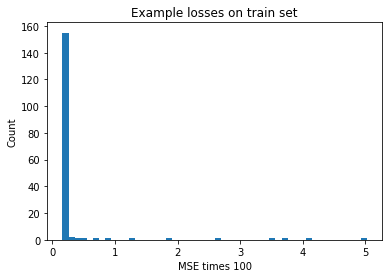

In [12]:
ex_metric = 'CHECKERBOARD_PEAK'
plt.hist(train_losses[metric], bins=50)
plt.title('Example losses on train set')
plt.xlabel('MSE times 100')
plt.ylabel('Count')
plt.show()

## Predict on test and calculate ROC AUC

The prediction is made first on the train set, so the LSTM can learn given metric and have a good hidden state. Then the prediction is made on the test set, but the anomalies are skipped, so the model won't try to predict the next day based on an anomaly.

In [14]:
def predict_test(model, X_train, X_test, y_train, y_test, losses_train, metric, threshold=0.99):
    anomaly = False
    X_dist_copy = deepcopy(X_test)
    y_dist_copy = deepcopy(y_test)
    state_h, state_c = np.zeros((1, 50)), np.zeros((1, 50))
    preds = []
    pred_proba = []
    pred_anom = []
    
    # prediction on train
    for day in X_train:
        expanded_day = np.expand_dims(np.expand_dims(day, 0), 0)
        pred, state_h, state_c = model.predict([expanded_day, state_h, state_c])

    # prediction on test with skipping anomalies
    for i, day in enumerate(X_dist_copy):
        if anomaly:
            day = old_day
            anomaly = False
        expanded_day = np.expand_dims(np.expand_dims(day, 0), 0)
        pred, state_h, state_c = model.predict([expanded_day, state_h, state_c])
        squeezed_pred = np.squeeze(np.squeeze(pred, 0), 0)
        preds.append(squeezed_pred)
        loss = mse_times_100_np(y_dist_copy[i], squeezed_pred)
        proba = percentile(losses_train[metric], loss)
        pred_proba.append(proba)
        pred_anom.append(int(proba > threshold))
        if proba > threshold:
            try:
                anomaly = True
                old_day = day
                X_dist_copy[i + 2] = np.abs(X_dist_copy[i + 2] - X_dist_copy[i + 1])
                y_dist_copy[i + 1] = np.abs(y_dist_copy[i + 1] - y_dist_copy[i])
            except IndexError:
                pass
    return X_dist_copy, preds, pred_proba, pred_anom

metric:  A11Y_CONSUMERS
auc:  0.9923986486486487


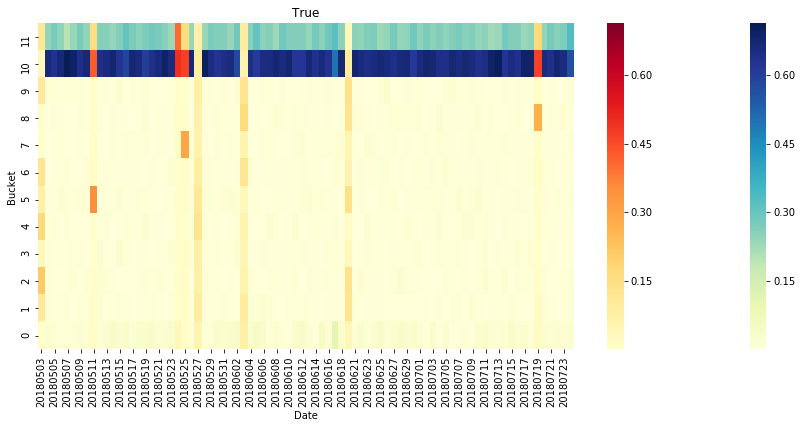

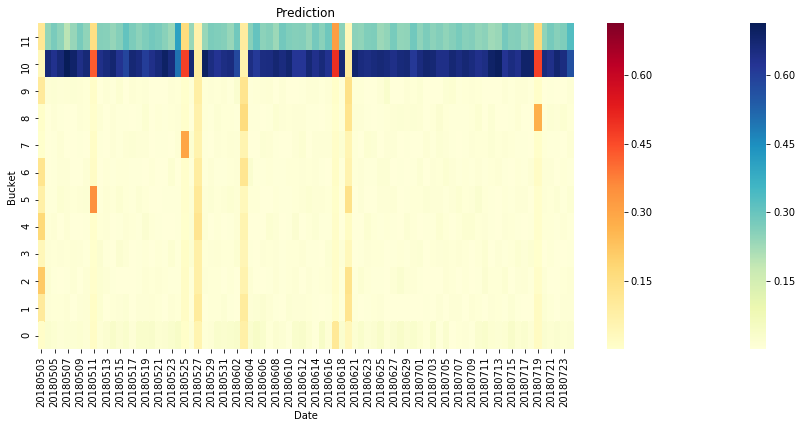

metric:  DEVTOOLS_PERFTOOLS_CONSOLE_RECORDING_COUNT
auc:  0.7777777777777778


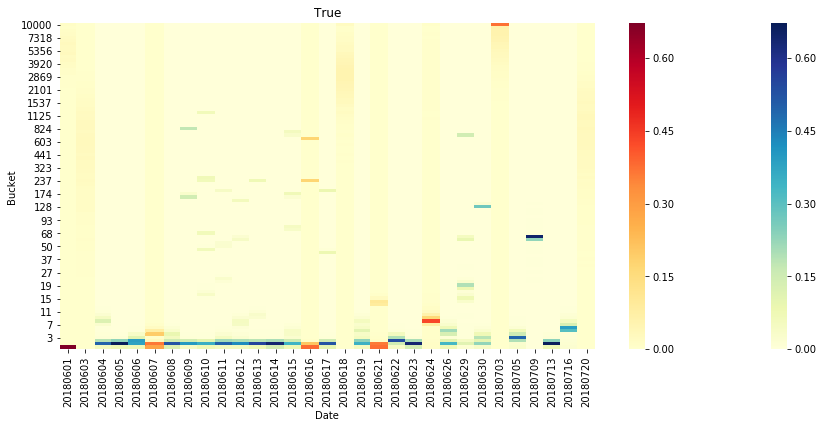

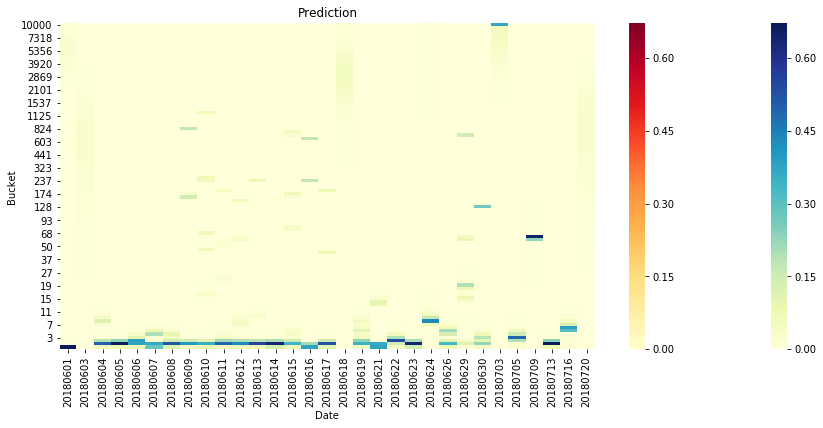

metric:  GC_BUDGET_OVERRUN
auc:  0.8834827144686299


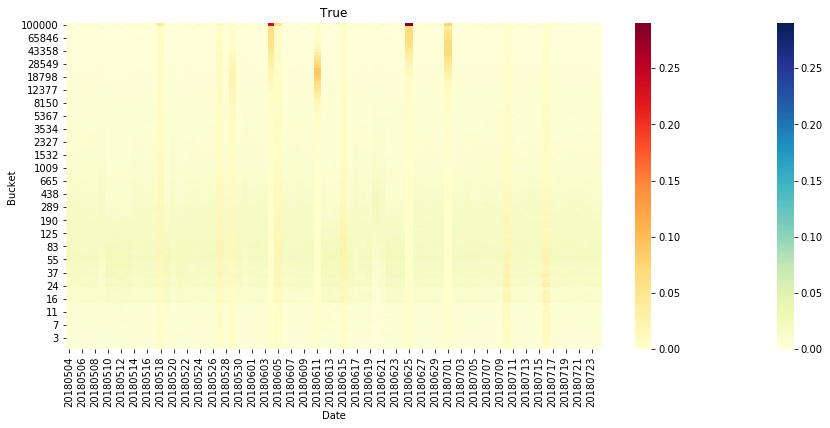

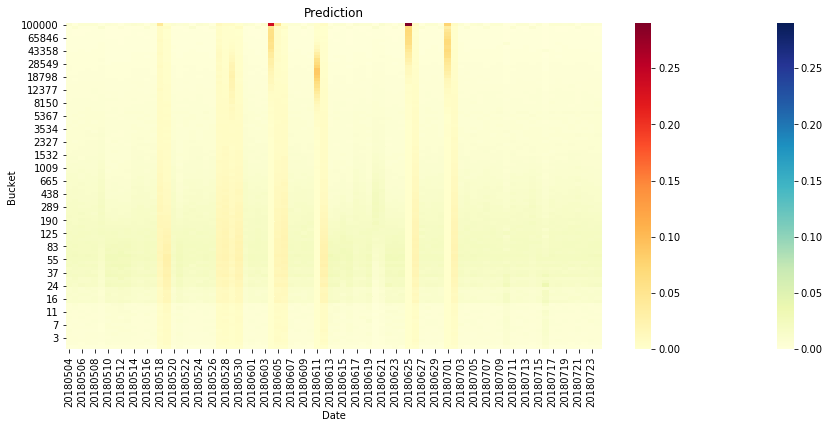

metric:  MEMORY_DISTRIBUTION_AMONG_CONTENT
auc:  0.9551856594110115


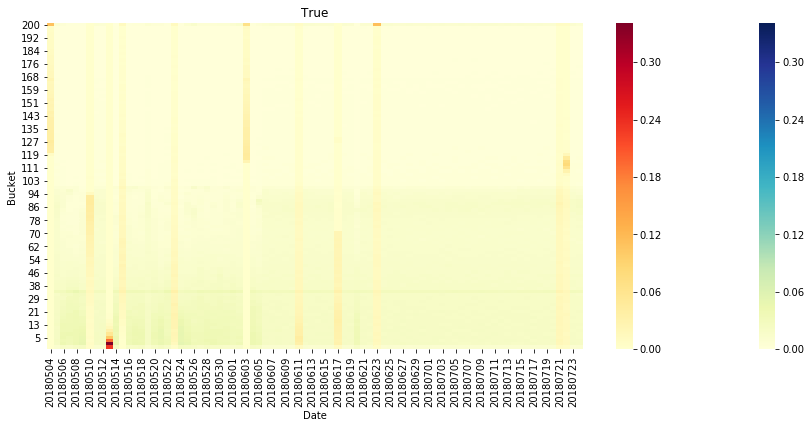

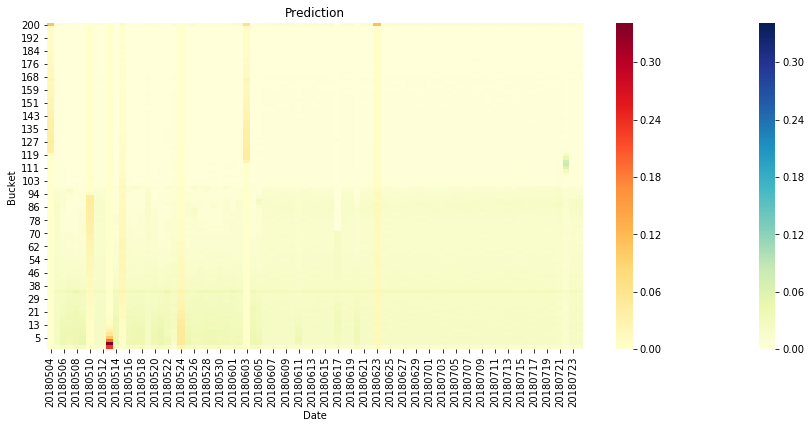

metric:  PWMGR_MANAGE_COPIED_PASSWORD
auc:  0.5041666666666667


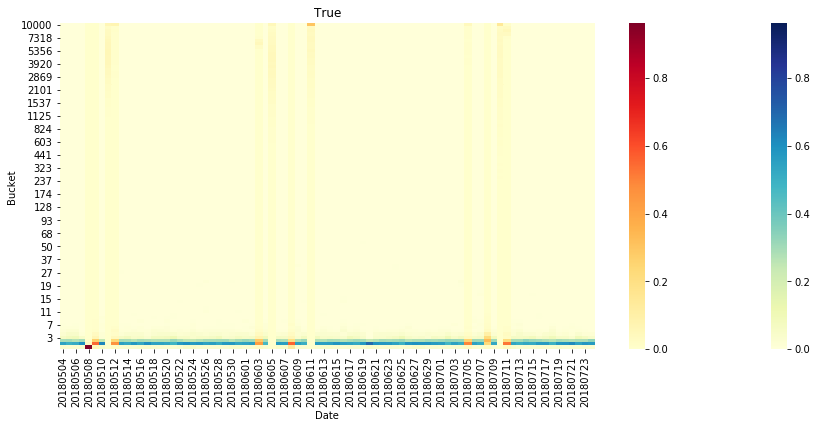

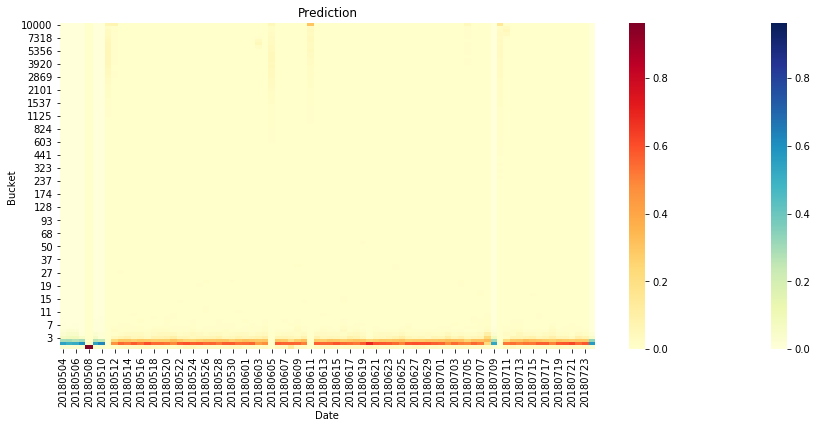

SHUTDOWN_PHASE_DURATION_TICKS
SIMPLE_MEASURES_ADDONMANAGER
SIMPLE_MEASURES
metric:  SSL_AUTH_ECDSA_CURVE_FULL
auc:  0.6942567567567568


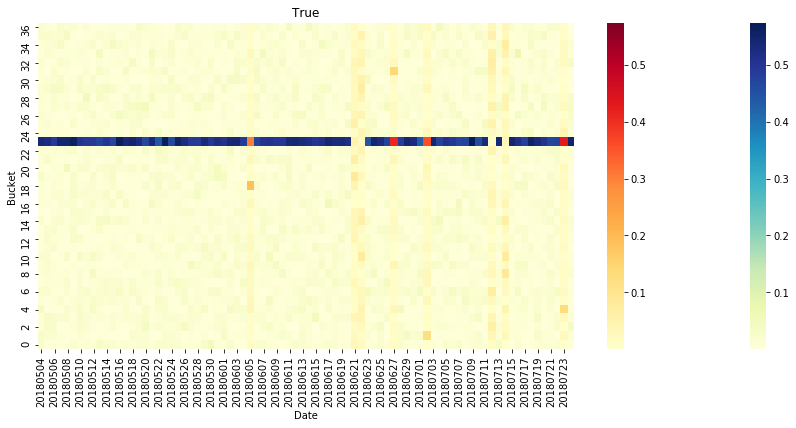

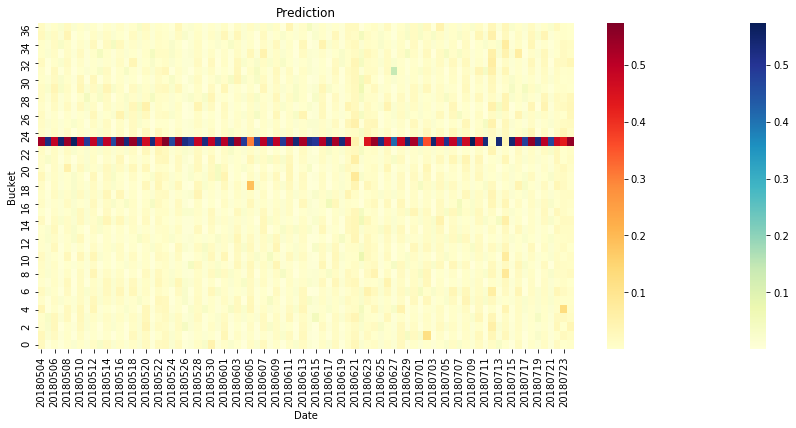

metric:  URLCLASSIFIER_LOOKUP_TIME_2
auc:  0.639269406392694


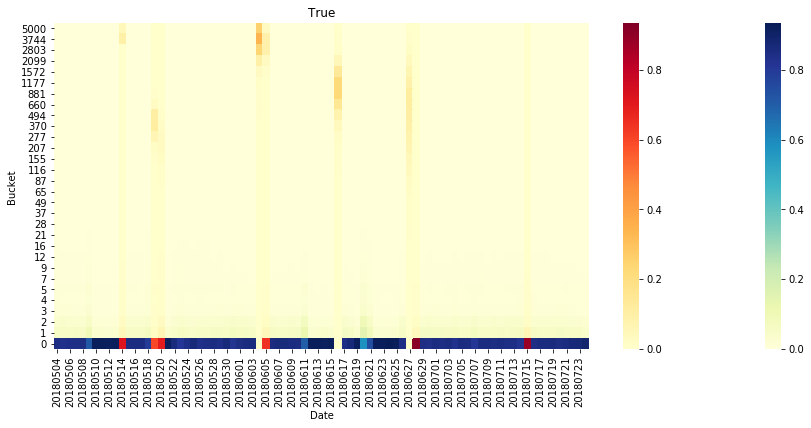

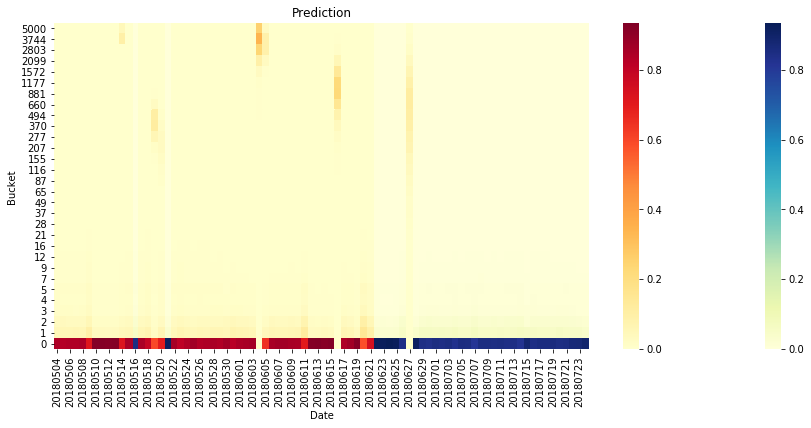

USE_COUNTER2_DEPRECATED
metric:  USE_COUNTER2_OFFLINERESOURCELIST_ONUPDATEREADY_getter_PAGE
auc:  0.7837837837837838


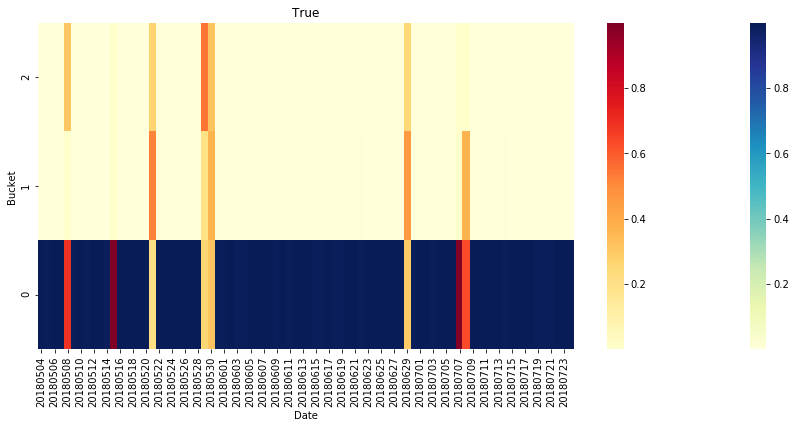

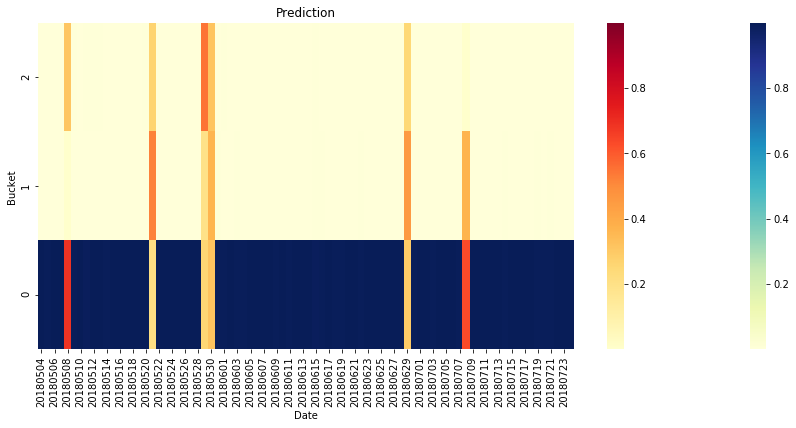

USE_COUNTER2


In [15]:
auc_list = []

for i, m in enumerate(X_test.keys()):
    try:
        X_test_dist_tmp, pred, pred_proba, pred_anom = predict_test(
            model_test, X_train_dists[m], X_test_dists[m], 
            y_train_dists[m], y_test_dists[m], train_losses, m
        )

        # Make data frames
        X_test_df = X_metric_to_df(X_test[m]).iloc[:, 2:]
        y_df = pd.DataFrame(y_test_dists[m])
        y_anom_df = y_metric_to_df(y_anomalies[m]).iloc[2:, ]
        y_pred_df = pd.DataFrame(pred_anom)
        y_pred_proba_df = pd.DataFrame(pred_proba)
    
    except KeyError:
        print(m)
        continue

    # Check if there are two classes in test set, AUC is not defined otherwise
    if len(np.unique(np.array(y_anom_df[0]))) > 1:
        auc_score = roc_auc_score(np.array(y_anom_df.iloc[:, 0]), np.array(y_pred_proba_df.iloc[:, 0]))
        auc_list.append(auc_score)

        if i % 200 == 0:
            print('metric: ', m)
            print('auc: ', auc_score)
            plot_preds(X_test_df, y_anom_df, y_pred_df)

In [16]:
print('Mean ROC AUC: ', np.mean(auc_list))

Mean ROC AUC:  0.8084029525027528


The average ROC AUC for all metrics is 0.81.